In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from PIL import Image
import glob
import os
import cv2
from tempfile import TemporaryFile

## Some x-ray pictures

In [24]:
healthy_clear_path = 'chest_xray/train/NORMAL/IM-0384-0001.jpeg'
sick_bact_clear_path = 'chest_xray/train/PNEUMONIA/person751_bacteria_2654.jpeg'
sick_virus_clear_path = 'chest_xray/train/PNEUMONIA/person771_virus_1399.jpeg'
health_unclear_path = 'chest_xray/train/NORMAL/IM-0385-0001.jpeg'
sick_bact_unclear_path = 'chest_xray/train/PNEUMONIA/person775_bacteria_2679.jpeg'
sick_virus_unclear_path = 'chest_xray/train/PNEUMONIA/person773_virus_1402.jpeg'

In [25]:
# A clearly healthy lung
healthy_clear_img = Image.open(healthy_clear_path)
healthy_clear_img.show()

In [26]:
# A clearly sick (bacteria) lung
sick_bact_clear_img = Image.open(sick_bact_clear_path)
sick_bact_clear_img.show()

In [27]:
# A clearly sick (virus) lung
sick_virus_clear_img = Image.open(sick_virus_clear_path)
sick_virus_clear_img.show()

In [28]:
# An unclear healthy lung
healthy_unclear_img = Image.open(health_unclear_path)
healthy_unclear_img.show()

In [29]:
# An unclear sick (bacteria) lung
sick_bact_unclear_img = Image.open(sick_bact_unclear_path)
sick_bact_unclear_img.show()

In [30]:
# An unclear sick (virus) lung
sick_virus_unclear_img = Image.open(sick_virus_unclear_path)
sick_virus_unclear_img.show()

## Transformed images

In [31]:
data_dir = 'chest_xray'

In [32]:
data_paths = [os.path.join(pth, f) for pth, dirs, files in os.walk(data_dir) for f in files if '.jpeg' in f]
image_list = []
for filename in data_paths:
    img = cv2.imread(filename)
    height, width, _ = np.array(img).shape
    if height > width:
        resize_img = cv2.resize(img,(256, int(round(256*height/width))))
    else:
        resize_img = cv2.resize(img,(round(256*width/height), 256))
    height, width, _ = np.array(resize_img).shape
    left = int(round(width/2)-224/2)
    right = int(round(width/2)+224/2)
    lower = int(round(height/2)+224/2)
    upper = int(round(height/2)-224/2)
    crop_img = resize_img[upper:lower, left:right, 0]
    image_list.append(crop_img)
print(len(image_list))

5856


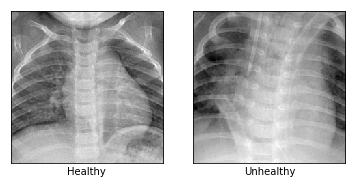

In [65]:
img = cv2.imread(health_unclear_path)
height, width, _ = np.array(img).shape
fig, ax = plt.subplots(1,2, subplot_kw={'xticks':[], 'yticks':[]})
if height > width:
    resize_img = cv2.resize(img,(256, int(round(256*height/width))))
else:
    resize_img = cv2.resize(img,(round(256*width/height), 256))
height, width, _ = np.array(resize_img).shape
left = int(round(width/2)-224/2)
right = int(round(width/2)+224/2)
lower = int(round(height/2)+224/2)
upper = int(round(height/2)-224/2)
crop_img = resize_img[upper:lower, left:right, 0]
ax[0].imshow(crop_img, cmap='binary_r')
ax[0].set_xlabel('Healthy')

img = cv2.imread(sick_virus_unclear_path)
height, width, _ = np.array(img).shape
if height > width:
    resize_img = cv2.resize(img,(256, int(round(256*height/width))))
else:
    resize_img = cv2.resize(img,(round(256*width/height), 256))
height, width, _ = np.array(resize_img).shape
left = int(round(width/2)-224/2)
right = int(round(width/2)+224/2)
lower = int(round(height/2)+224/2)
upper = int(round(height/2)-224/2)
crop_img = resize_img[upper:lower, left:right, 0]
ax[1].imshow(crop_img, cmap='binary_r')
ax[1].set_xlabel('Unhealthy')
plt.show()

fig.savefig('comparison.png')

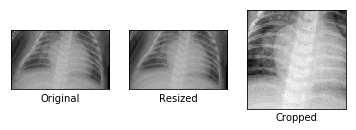

In [54]:
img = cv2.imread(sick_bact_clear_path)
height, width, _ = np.array(img).shape
fig, ax = plt.subplots(1,3, subplot_kw={'xticks':[], 'yticks':[]})
ax[0].imshow(img)
ax[0].set_xlabel('Original')
if height > width:
    resize_img = cv2.resize(img,(256, int(round(256*height/width))))
else:
    resize_img = cv2.resize(img,(round(256*width/height), 256))
ax[1].imshow(resize_img)
ax[1].set_xlabel('Resized')
height, width, _ = np.array(resize_img).shape
left = int(round(width/2)-224/2)
right = int(round(width/2)+224/2)
lower = int(round(height/2)+224/2)
upper = int(round(height/2)-224/2)
crop_img = resize_img[upper:lower, left:right, 0]
ax[2].imshow(crop_img, cmap='binary_r')
ax[2].set_xlabel('Cropped')
plt.show()

fig.savefig('data_transform.png')

In [34]:
image_arr = np.array(image_list)
print(image_arr.shape)
img_data = np.reshape(image_arr, (len(image_list),224*224))
print(img_data.shape)

(5856, 224, 224)
(5856, 50176)


In [51]:
np.savetxt('cleaned_data.txt', img_data, fmt='%d')

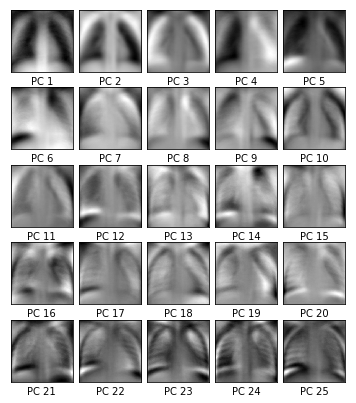

In [35]:
pca = PCA(n_components=500, svd_solver='randomized')
pca.fit(img_data)

fig, axes = plt.subplots(5, 5, figsize=(6, 7), subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(224, 224), cmap='binary_r')
    ax.set_xlabel('PC %d' % (i+1))
    
fig.savefig('eigenlung.png')

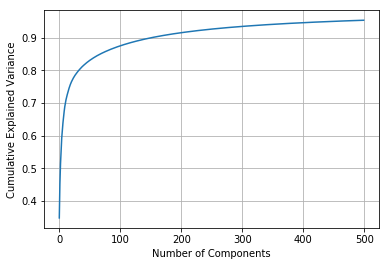

In [36]:
fig = plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
fig.savefig('explained_variance.png')

## Models with PCA data

In [37]:
def image_processing(directory, label):
    data_paths = [os.path.join(pth, f) for pth, dirs, files in os.walk(directory) for f in files if '.jpeg' in f]
    image_list = []
    for filename in data_paths:
        img = cv2.imread(filename)
        height, width, _ = np.array(img).shape
        if height > width:
            resize_img = cv2.resize(img,(256, int(round(256*height/width))))
        else:
            resize_img = cv2.resize(img,(round(256*width/height), 256))
        height, width, _ = np.array(resize_img).shape
        left = int(round(width/2)-224/2)
        right = int(round(width/2)+224/2)
        lower = int(round(height/2)+224/2)
        upper = int(round(height/2)-224/2)
        crop_img = resize_img[upper:lower, left:right, 0]
        image_list.append(crop_img)
    
    image_arr = np.array(image_list)
    img_data = np.reshape(image_arr, (len(image_list),224*224))
    img_data = np.append(img_data, np.full((len(image_list),1), label), axis=1)
    
    return img_data

In [38]:
train_pneumonia = '/train/PNEUMONIA'
train_normal = '/train/NORMAL'
val_pneumonia = '/val/PNEUMONIA'
val_normal = '/val/NORMAL'
test_pneumonia = '/test/PNEUMONIA'
test_normal = '/test/NORMAL'

train_pneumonia = image_processing(data_dir+train_pneumonia, 1)
print(train_pneumonia.shape)
train_normal = image_processing(data_dir+train_normal, 0)
print(train_normal.shape)
val_pneumonia = image_processing(data_dir+val_pneumonia, 1)
print(val_pneumonia.shape)
val_normal = image_processing(data_dir+val_normal, 0)
print(val_normal.shape)
test_pneumonia = image_processing(data_dir+test_pneumonia, 1)
print(test_pneumonia.shape)
test_normal = image_processing(data_dir+test_normal, 0)
print(test_normal.shape)

(3875, 50177)
(1341, 50177)
(8, 50177)
(8, 50177)
(390, 50177)
(234, 50177)


In [39]:
train = np.append(train_pneumonia, train_normal, axis=0)
train = shuffle(train, random_state=42)
print(train.shape)
val = np.append(val_pneumonia, val_normal, axis=0)
val = shuffle(val, random_state=42)
print(val.shape)
test = np.append(test_pneumonia, test_normal, axis=0)
test = shuffle(test, random_state=42)
print(test.shape)

(5216, 50177)
(16, 50177)
(624, 50177)


In [40]:
pca = PCA(n_components=150, svd_solver='randomized')
train_x_pca = pca.fit_transform(train[:,0:-1])
train_y = train[:,-1]
val_x_pca = pca.transform(val[:,0:-1])
val_y = val[:,-1]
test_x_pca = pca.transform(test[:,0:-1])
test_y = test[:,-1]

In [41]:
clf_logit = LogisticRegression(solver='lbfgs', max_iter=500).fit(train_x_pca, train_y)
train_acc = clf_logit.score(train_x_pca, train_y)
print('Train accuracy (logistic regression): %f' % train_acc)
val_acc = clf_logit.score(val_x_pca, val_y)
print('Validation accuracy (logistic regression): %f' % val_acc)
test_acc = clf_logit.score(test_x_pca, test_y)
print('Test accuracy (logistic regression): %f' % test_acc)

tn, fp, fn, tp = confusion_matrix(test_y, clf_logit.predict(test_x_pca)).ravel()
print('tn: %d, fp: %d, fn: %d, tp: %d' % (tn, fp, fn, tp))
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*(precision*recall)/(precision+recall)
print('f1: %f' % f1)

Train accuracy (logistic regression): 0.964916
Validation accuracy (logistic regression): 0.750000
Test accuracy (logistic regression): 0.759615
tn: 90, fp: 144, fn: 6, tp: 384
f1: 0.836601


In [42]:
clf_svm = LinearSVC(max_iter=50000).fit(train_x_pca, train_y)
train_acc = clf_svm.score(train_x_pca, train_y)
print('Train accuracy (Hard SVM): %f' % train_acc)
val_acc = clf_svm.score(val_x_pca, val_y)
print('Validation accuracy (Hard SVM): %f' % val_acc)
test_acc = clf_svm.score(test_x_pca, test_y)
print('Test accuracy (Hard SVM): %f' % test_acc)

tn, fp, fn, tp = confusion_matrix(test_y, clf_svm.predict(test_x_pca)).ravel()
print('tn: %d, fp: %d, fn: %d, tp: %d' % (tn, fp, fn, tp))
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*(precision*recall)/(precision+recall)
print('f1: %f' % f1)

Train accuracy (Hard SVM): 0.899156
Validation accuracy (Hard SVM): 0.687500
Test accuracy (Hard SVM): 0.766026
tn: 103, fp: 131, fn: 15, tp: 375
f1: 0.837054


/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [43]:
# penalty = 1
# clf_svm_soft = svm.SVC(kernel='linear', C=penalty).fit(train_x_pca, train_y)
# train_acc = clf_svm_soft.score(train_x_pca, train_y)
# print('Train accuracy (Soft SVM): %f' % train_acc)
# val_acc = clf_svm_soft.score(val_x_pca, val_y)
# print('Validation accuracy (Soft SVM): %f' % val_acc)
# # test_acc = clf_svm.score(test_x_pca, test_y)
# # print('Test accuracy (Soft SVM): %f' % test_acc)

In [44]:
clf_lda = LinearDiscriminantAnalysis().fit(train_x_pca, train_y)
train_acc = clf_lda.score(train_x_pca, train_y)
print('Train accuracy (LDA): %f' % train_acc)
val_acc = clf_lda.score(val_x_pca, val_y)
print('Validation accuracy (LDA): %f' % val_acc)
test_acc = clf_lda.score(test_x_pca, test_y)
print('Test accuracy (LDA): %f' % test_acc)

tn, fp, fn, tp = confusion_matrix(test_y, clf_lda.predict(test_x_pca)).ravel()
print('tn: %d, fp: %d, fn: %d, tp: %d' % (tn, fp, fn, tp))
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*(precision*recall)/(precision+recall)
print('f1: %f' % f1)

Train accuracy (LDA): 0.957630
Validation accuracy (LDA): 0.812500
Test accuracy (LDA): 0.775641
tn: 100, fp: 134, fn: 6, tp: 384
f1: 0.845815


In [45]:
clf_rf = RandomForestClassifier(n_estimators=500, criterion='entropy', max_depth=5, 
                                max_features='auto').fit(train_x_pca, train_y)
train_acc = clf_rf.score(train_x_pca, train_y)
print('Train accuracy (Random Forest): %f' % train_acc)
val_acc = clf_rf.score(val_x_pca, val_y)
print('Validation accuracy (Random Forest): %f' % val_acc)
test_acc = clf_rf.score(test_x_pca, test_y)
print('Test accuracy (Random Forest): %f' % test_acc)

tn, fp, fn, tp = confusion_matrix(test_y, clf_rf.predict(test_x_pca)).ravel()
print('tn: %d, fp: %d, fn: %d, tp: %d' % (tn, fp, fn, tp))
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*(precision*recall)/(precision+recall)
print('f1: %f' % f1)

Train accuracy (Random Forest): 0.891488
Validation accuracy (Random Forest): 0.500000
Test accuracy (Random Forest): 0.647436
tn: 15, fp: 219, fn: 1, tp: 389
f1: 0.779559


In [46]:
clf_gbm = GradientBoostingClassifier(n_estimators=100).fit(train_x_pca, train_y)
train_acc = clf_gbm.score(train_x_pca, train_y)
print('Train accuracy (Gradient Boosting): %f' % train_acc)
val_acc = clf_gbm.score(val_x_pca, val_y)
print('Validation accuracy (Gradient Boosting): %f' % val_acc)
test_acc = clf_gbm.score(test_x_pca, test_y)
print('Test accuracy (Gradient Boosting): %f' % test_acc)

tn, fp, fn, tp = confusion_matrix(test_y, clf_gbm.predict(test_x_pca)).ravel()
print('tn: %d, fp: %d, fn: %d, tp: %d' % (tn, fp, fn, tp))
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*(precision*recall)/(precision+recall)
print('f1: %f' % f1)

Train accuracy (Gradient Boosting): 0.980061
Validation accuracy (Gradient Boosting): 0.562500
Test accuracy (Gradient Boosting): 0.766026
tn: 99, fp: 135, fn: 11, tp: 379
f1: 0.838496


In [74]:
all_healthy = 234/(234+390)
print('Test accuracy (All Healthy): %f' % all_healthy)

tn, fp, fn, tp = confusion_matrix(test_y, np.zeros((1,len(test_y))).flatten()).ravel()
print('tn: %d, fp: %d, fn: %d, tp: %d' % (tn, fp, fn, tp))
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*(precision*recall)/(precision+recall)
print('f1: %f' % f1)

Test accuracy (All Healthy): 0.375000
tn: 234, fp: 0, fn: 390, tp: 0
f1: nan


/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


In [75]:
all_healthy = 390/(234+390)
print('Test accuracy (All Healthy): %f' % all_healthy)

tn, fp, fn, tp = confusion_matrix(test_y, np.ones((1,len(test_y))).flatten()).ravel()
print('tn: %d, fp: %d, fn: %d, tp: %d' % (tn, fp, fn, tp))
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*(precision*recall)/(precision+recall)
print('f1: %f' % f1)

Test accuracy (All Healthy): 0.625000
tn: 0, fp: 234, fn: 0, tp: 390
f1: 0.769231
